# Import

In [71]:
# python lib
import os
import sys
import math
import numpy as np
import random
import gast
# other lib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

util_path = "../Utils"
random.seed(42)

# Configs

In [203]:
CONFIG = {
    "SAMPLE_NUM":100000,
    "SAMPLE_SPLIT_RATE":0.2,
    "SAMPLE_RANGE":(-10, 10)
}

# Ready for dataset

## Target function:
\begin{align*}
    f(x) = \frac{\sin\left(\pi x \right)}{\pi x}
\end{align*}

in here, 
$x \in [-3,3] $, and $\varepsilon \sim U(0,1)$    

In [204]:
def function(x):
    return np.sin(np.pi * x) / (np.pi * x)
def standardization(x):
    return (x - x.mean()) / x.std()
gen_x = np.random.uniform(*CONFIG["SAMPLE_RANGE"], CONFIG["SAMPLE_NUM"])
gen_x = standardization(gen_x)
gen_y = function(gen_x)
x_train, x_test, y_train, y_test = train_test_split(gen_x, gen_y, random_state=91, test_size=0.1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(90000,) (10000,) (90000,) (10000,)


# Define getting result function

In [250]:
def get_result(function_name, loss_function):
    inputs = Input(shape=(1))
    layer = Dense(8, activation="relu")(inputs)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(4, activation="relu")(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1)(layer)
    model = Model(inputs, layer)
    model_path = f"./model/{function_name}.h5"
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=3
        ),
        ModelCheckpoint(
            filepath=model_path,
            save_best_only=True,
            save_weights_only=True,
            verbose=0
        )
    ]
    model.compile(
        optimizer="adam",
        loss=loss_function,
        metrics=["mse"]
    )
    
    model.fit(
        x_train,
        y_train,
        verbose=0,
        batch_size=512,
        epochs=10,
        callbacks=callbacks,
        validation_split=0.1
    )
    model.load_weights(model_path)
    pred = model.predict(x_test)
    return pred

# Define loss function

## MSE
\begin{align*}
    MSE = \frac{\sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^{2}}{n}
\end{align*}

## Cross Entropy Loss
\begin{align*}
    CE = -\sum_{i}^{C}t_{i}log(f(s)_{i})
\end{align*}

## ArcFaceLoss
\begin{align*}
    L_{3} = -\frac{1}{N}\sum_{i=1}^{N}log\frac{e^{s(cos(\theta_{yi + m}))}}{e^{s(cos(\theta_{yi + m}))} + \sum_{j=1, j \neq y_{i}}e^{scos\theta_{j}}}
\end{align*}

In [254]:
class MSELoss(Loss):
    def __init__(self, **kwargs):
        super(MSELoss, self).__init__(**kwargs)
    def __call__(self, y_pred, y_true, sample_weight=None):
        return K.mean(K.square(K.cast_to_floatx(y_true) - K.cast_to_floatx(y_pred)))

class CrossEntropyLoss(Loss):
    def __init__(self, **kwargs):
        super(CrossEntropyLoss, self).__init__(**kwargs)
        self.delta = 1e-14
    def __call__(self, y_pred, y_true, sample_weight=None):
        y_pred = tf.nn.softmax(y_pred)
        return -K.sum(K.cast_to_floatx(y_true) * K.log(K.l2_normalize(K.cast_to_floatx(y_pred)) + self.delta))


# Loss function dict

In [259]:
loss_function = {
    "MSE":MSELoss(),
    "CrossEntropyLoss":CrossEntropyLoss(),
}

# Get result

313/313 [==============================] - 1s 2ms/step


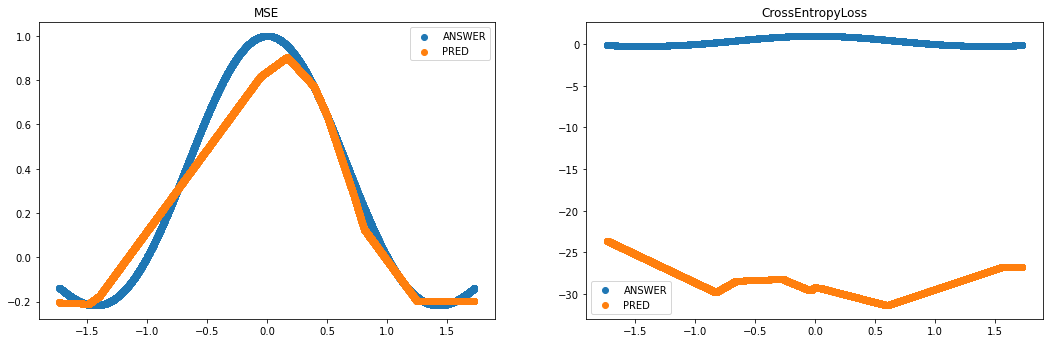

In [260]:
fig = plt.figure(figsize=(18, 6 * len(loss_function)))
for index, (function_name, loss_f) in enumerate(loss_function.items()):
    ax = fig.add_subplot(len(loss_function), 2, index + 1)
    pred = get_result(function_name, loss_f)
    ax.scatter(x_test, y_test)
    ax.scatter(x_test, pred)
    ax.legend(["ANSWER", "PRED"])
    ax.set_title(function_name)